In [113]:
#Section 1: Decision Tree
#Single class decision tree 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Loading the dataset
test_data = pd.read_csv('TargetData.csv')


#Print the first 5 rows of the dataframe.
test_data.head()

#X consists of 58 features. Each feature represents 1 test in the long test flow.
X = test_data.drop(["ID","SB","COL","Margin","Block","ROW"],axis = 1)
#Y can be one of ROW,COL,SB. ROW means the failure is on a row of memory array. 
#COL means the failure is on a column of the cell array.
#SB is single bit failure inside the memory.
y = test_data.ROW #COL #SB

In [114]:
#post pruning function on decision tree
from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

In [115]:
#multi-class decision tree which will be evaluate to choose the best method

#Forming 8 class from 3 columns, coded as 0 to 7
#['Overkill','SB','COL','SB+COL','ROW','ROW+SB','ROW+COL','SB+ROW+COL']
#y = test_data.SB+2*test_data.COL+4*test_data.ROW
y=test_data[["SB","COL","ROW"]].as_matrix()
'''
for r in range(len(test_data)):
    print(test_data.iloc[r].SB,test_data.iloc[r].COL,test_data.iloc[r].ROW,y[r])
raise
'''

#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=2, stratify=y)

from sklearn.tree import DecisionTreeClassifier

#select best depth
max_accuracy=0
best_depth=12
best_impurity_decrease=0.0001
best_weight_fraction_leaf=0.001
for DEPTH in range(20,40,1):
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=DEPTH,random_state=0,min_impurity_decrease=0.0001,min_weight_fraction_leaf=0.001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(DEPTH,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_depth=DEPTH
#select best impurity decrease        
for impurity_decrease in range(5,20,1):

    dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=impurity_decrease*0.00001,min_weight_fraction_leaf=0.001)
    dt.fit(X_train, y_train)

    #post_pruning
    prune_duplicate_leaves(dt)

    print(best_depth,impurity_decrease,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_impurity_decrease=impurity_decrease*0.00001
#select weight fraction leaf        
for weight_fraction_leaf in range(5,15,1):
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=best_impurity_decrease,min_weight_fraction_leaf=weight_fraction_leaf*0.0001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(best_depth,best_impurity_decrease,weight_fraction_leaf,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_weight_fraction_leaf=weight_fraction_leaf*0.0001

        
    

dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=best_impurity_decrease,min_weight_fraction_leaf=best_weight_fraction_leaf)
dt.fit(X_train, y_train)    

#post_pruning
prune_duplicate_leaves(dt)

print("selected depth: {:d}".format(best_depth))
print("selected best_impurity_decrease: {:.8f}".format(best_impurity_decrease))
print("selected best_weight_fraction_leaf: {:.8f}".format(best_weight_fraction_leaf))
print("Accuracy on training set: {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test, y_test)))

20 0.5227934044616876
21 0.5266731328806984
22 0.5286129970902037
23 0.5412221144519883
24 0.5489815712900097
25 0.5518913676042677
26 0.5499515033947624
27 0.5489815712900097
28 0.5615906886517944
29 0.5645004849660524
30 0.5635305528612997
31 0.5635305528612997
32 0.5596508244422891
33 0.5615906886517944
34 0.5586808923375364
35 0.5577109602327837
36 0.5577109602327837
37 0.5577109602327837
38 0.5577109602327837
39 0.5577109602327837
29 5 0.565470417070805
29 6 0.565470417070805
29 7 0.565470417070805
29 8 0.5645004849660524
29 9 0.5645004849660524
29 10 0.5645004849660524
29 11 0.5645004849660524
29 12 0.5645004849660524
29 13 0.5645004849660524
29 14 0.5635305528612997
29 15 0.5635305528612997
29 16 0.5635305528612997
29 17 0.5635305528612997
29 18 0.5635305528612997
29 19 0.5635305528612997
29 5e-05 5 0.5645004849660524
29 5e-05 6 0.5645004849660524
29 5e-05 7 0.5645004849660524
29 5e-05 8 0.5645004849660524
29 5e-05 9 0.5645004849660524
29 5e-05 10 0.565470417070805
29 5e-05 11 0

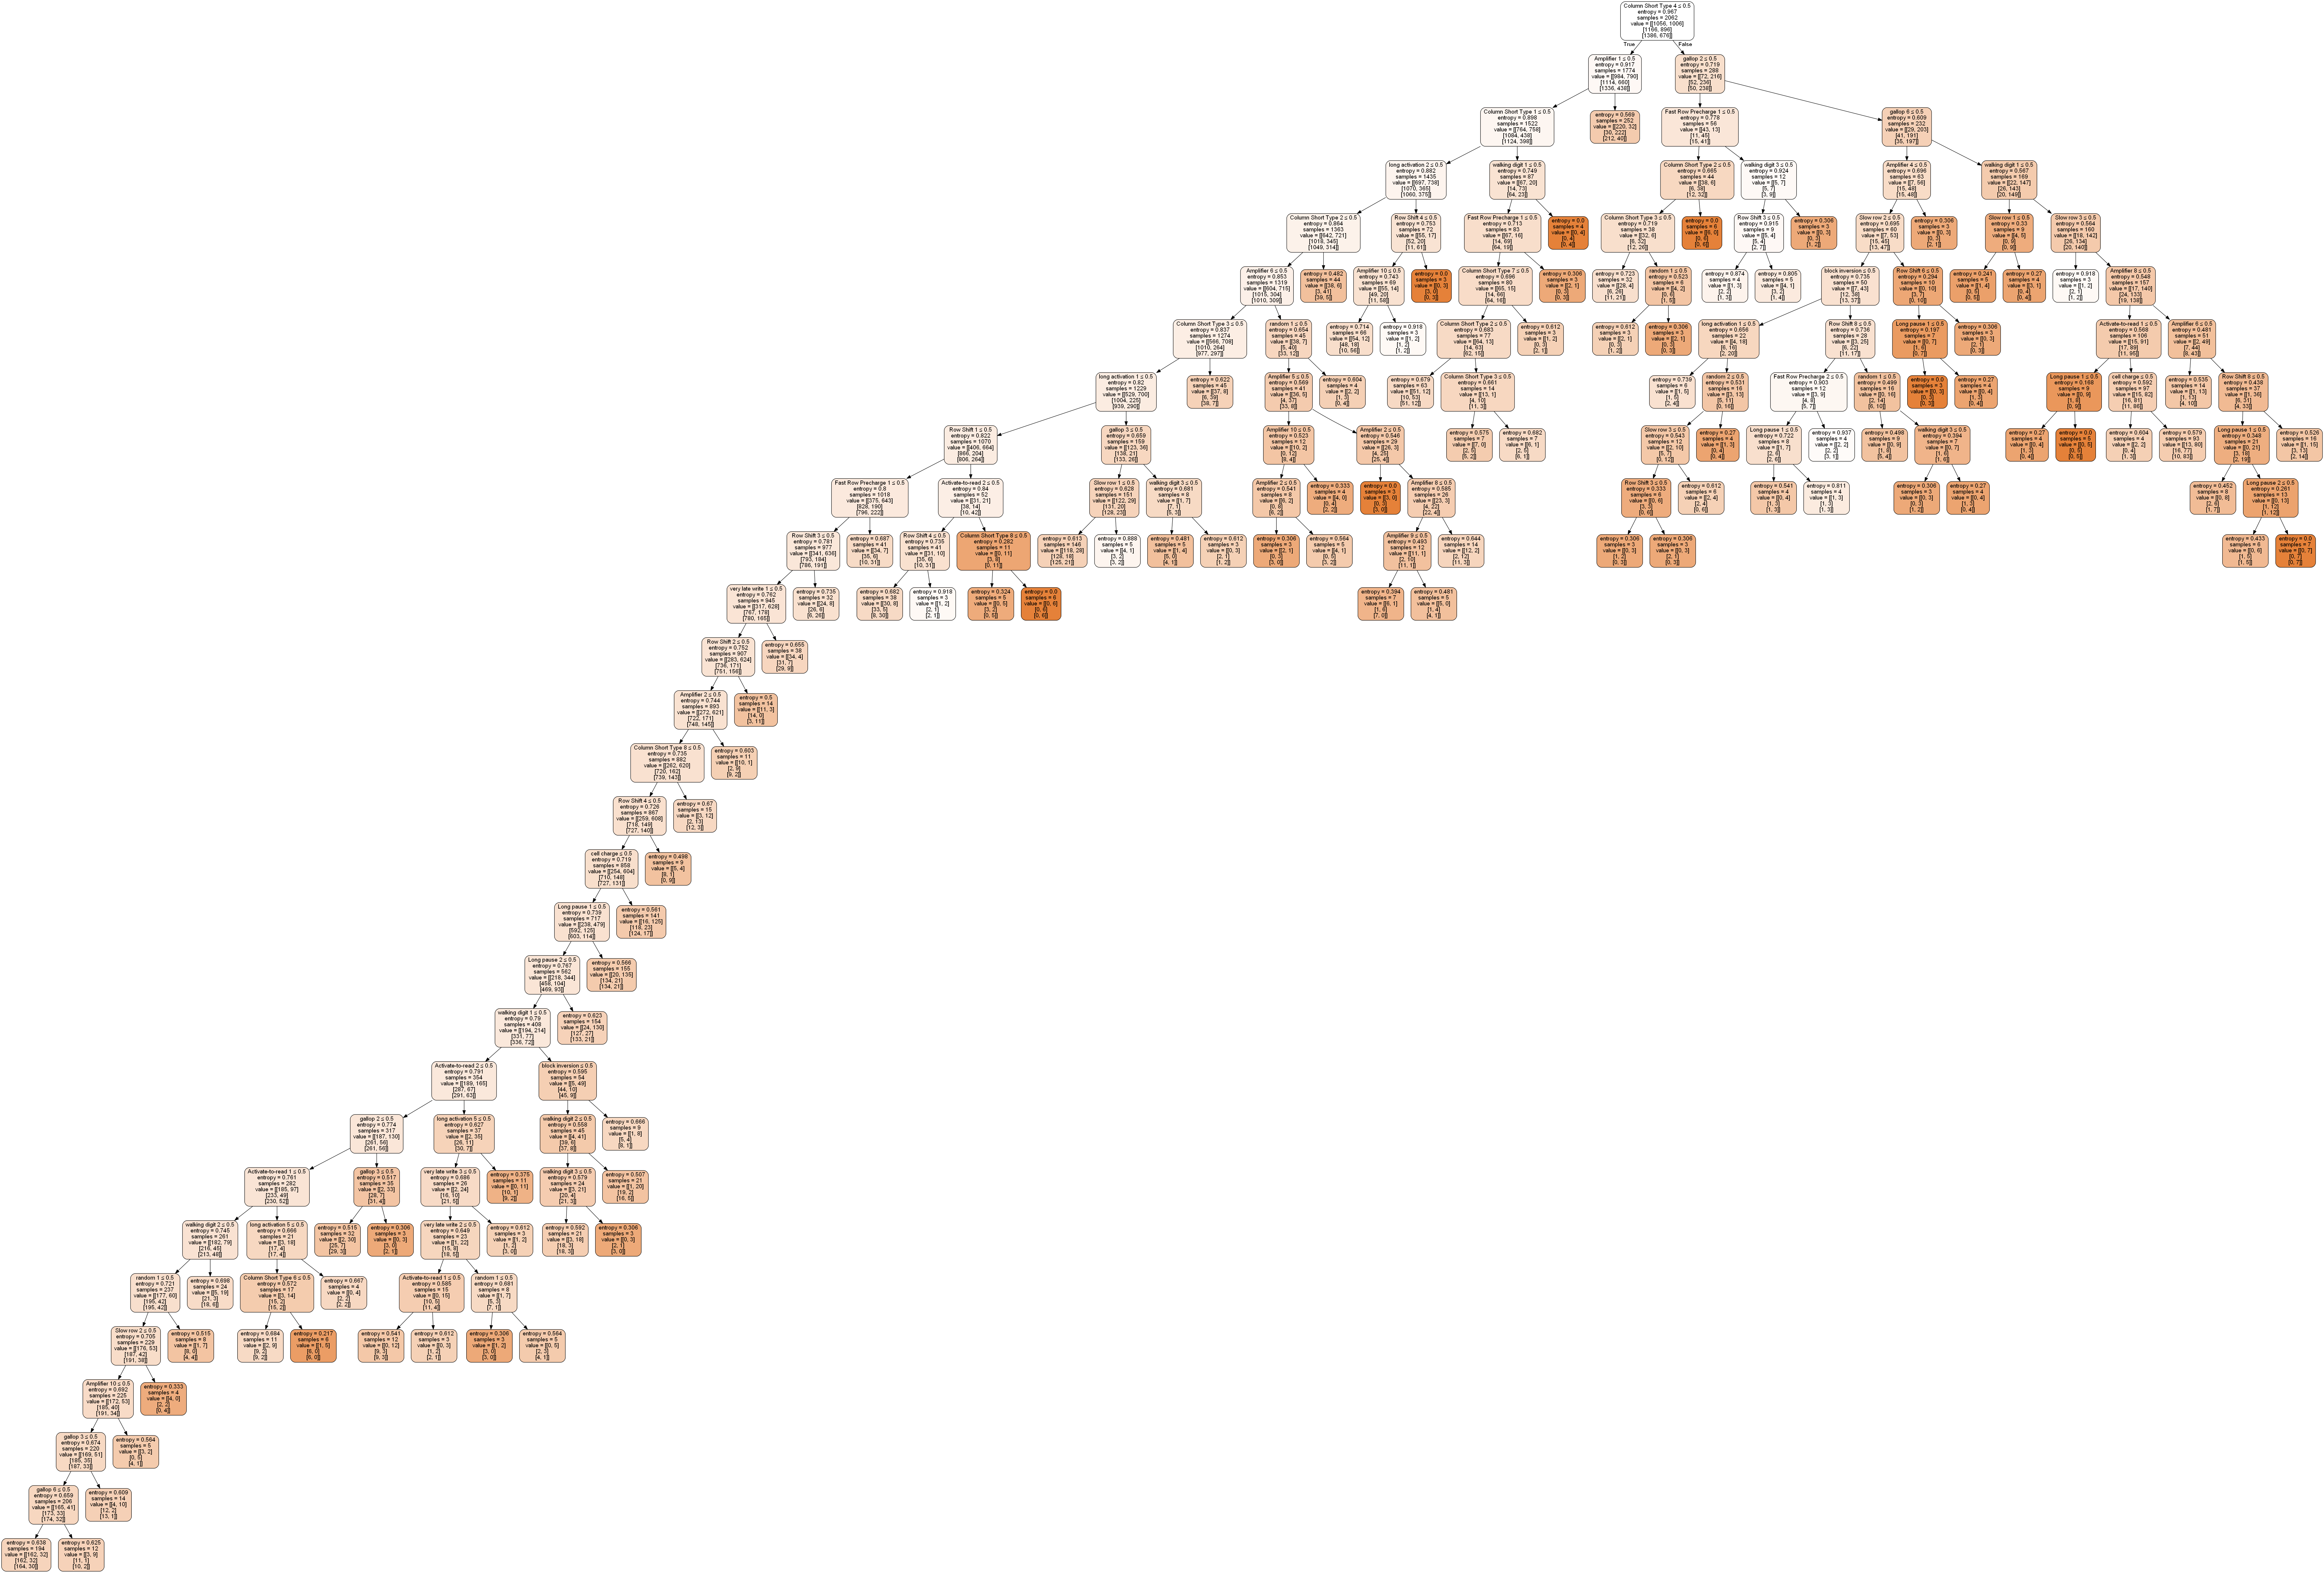

In [116]:
#DT visualizatin method 3
#!conda install -y pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#os.environ["PATH"] += os.pathsep + 'C:/Users/boonping/graphviz-2.38/release/bin'

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns,class_names=['Overkill','SB','COL','SB+COL','ROW','ROW+SB','ROW+COL','SB+ROW+COL'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('testClassified.png')
Image(graph.create_png())

In [117]:
#multi-class decision tree
y_pred = dt.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix,  multilabel_confusion_matrix  

print(multilabel_confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[[459  69]
  [111 392]]

 [[528  56]
  [122 325]]

 [[654  39]
  [143 195]]]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       503
           1       0.85      0.73      0.79       447
           2       0.83      0.58      0.68       338

   micro avg       0.85      0.71      0.77      1288
   macro avg       0.85      0.69      0.76      1288
weighted avg       0.85      0.71      0.77      1288
 samples avg       0.68      0.60      0.62      1288



In [118]:
print(dt.feature_importances_)
#print(sorted(dt.feature_importances_))

ranked_feature=[]
for i in range(58):
    ranked_feature.append('')
sorted_importance=sorted(dt.feature_importances_)
for i in range( len(dt.feature_importances_) ):
    if dt.feature_importances_[i]>0.20*sorted_importance[-1] or sorted_importance.index(dt.feature_importances_[i]) > len(dt.feature_importances_)-best_depth-1:
        #print(i)
        ranked_feature[57-sorted_importance.index(dt.feature_importances_[i])]=test_data.columns[i+1]
        
for f in ranked_feature:
    if f != "":
        print(f)
    

[0.01148217 0.0319127  0.         0.03656403 0.0272696  0.04590234
 0.01683612 0.00215048 0.04312544 0.01537604 0.00999687 0.02394593
 0.00939839 0.03995885 0.14652196 0.00831121 0.01752259 0.04284068
 0.04407808 0.20269632 0.001665   0.00286166 0.0035136  0.00563348
 0.01166045 0.01382674 0.02595806 0.01499894 0.         0.
 0.         0.00088341 0.         0.01329796 0.00795755 0.01654134
 0.00112946 0.0276796  0.         0.00115077 0.00153161 0.00157746
 0.         0.0385229  0.         0.00151142 0.         0.00138264
 0.         0.         0.00199389 0.00357039 0.01249064 0.00080997
 0.00094221 0.00817946 0.         0.00283961]
Column Short Type 4
Amplifier 1
Column Short Type 1
gallop 2
Column Short Type 2
long activation 2
Column Short Type 3
Amplifier 6
Fast Row Precharge 1
long activation 1
Activate-to-read 2
Row Shift 1
Row Shift 3
walking digit 1
Long pause 2
very late write 1
Row Shift 4
Long pause 1
random 1
Row Shift 2
Amplifier 2
Column Short Type 8
gallop 3
cell charge


In [119]:
scaler = StandardScaler()  
scaler.fit(X_train)
X_test1=X_test
X_test2=X_test
X_train = scaler.transform(X_train)  
X_test1 = scaler.transform(X_test1)  

from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000,verbose=2)  
mlp.fit(X_train, y_train)  

predictions = mlp.predict(X_test1)  


print("Accuracy", metrics.accuracy_score(y_test, predictions))
print(multilabel_confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(mlp.coefs_[0][1])

Iteration 1, loss = 2.29849120
Iteration 2, loss = 2.10942242
Iteration 3, loss = 2.01691414
Iteration 4, loss = 1.95979667
Iteration 5, loss = 1.92416445
Iteration 6, loss = 1.89512054
Iteration 7, loss = 1.86890899
Iteration 8, loss = 1.84642917
Iteration 9, loss = 1.83173625
Iteration 10, loss = 1.82051981
Iteration 11, loss = 1.81040826
Iteration 12, loss = 1.80091252
Iteration 13, loss = 1.79118177
Iteration 14, loss = 1.78354092
Iteration 15, loss = 1.77382161
Iteration 16, loss = 1.76587544
Iteration 17, loss = 1.75832387
Iteration 18, loss = 1.75009757
Iteration 19, loss = 1.74192631
Iteration 20, loss = 1.73378457
Iteration 21, loss = 1.72583824
Iteration 22, loss = 1.71778690
Iteration 23, loss = 1.71010719
Iteration 24, loss = 1.70201679
Iteration 25, loss = 1.69425624
Iteration 26, loss = 1.68690406
Iteration 27, loss = 1.67844149
Iteration 28, loss = 1.67077130
Iteration 29, loss = 1.66189956
Iteration 30, loss = 1.65381007
Iteration 31, loss = 1.64465473
Iteration 32, los

Iteration 256, loss = 1.20551628
Iteration 257, loss = 1.20532318
Iteration 258, loss = 1.20637019
Iteration 259, loss = 1.20505556
Iteration 260, loss = 1.20511556
Iteration 261, loss = 1.20419670
Iteration 262, loss = 1.20398031
Iteration 263, loss = 1.20381104
Iteration 264, loss = 1.20401753
Iteration 265, loss = 1.20392791
Iteration 266, loss = 1.20386111
Iteration 267, loss = 1.20381049
Iteration 268, loss = 1.20317168
Iteration 269, loss = 1.20280888
Iteration 270, loss = 1.20211313
Iteration 271, loss = 1.20188391
Iteration 272, loss = 1.20262995
Iteration 273, loss = 1.20217989
Iteration 274, loss = 1.20116116
Iteration 275, loss = 1.20140645
Iteration 276, loss = 1.20141312
Iteration 277, loss = 1.20115072
Iteration 278, loss = 1.20071271
Iteration 279, loss = 1.20150651
Iteration 280, loss = 1.20040134
Iteration 281, loss = 1.20076797
Iteration 282, loss = 1.19981460
Iteration 283, loss = 1.20039931
Iteration 284, loss = 1.20028265
Iteration 285, loss = 1.20056154
Iteration 

Iteration 528, loss = 1.16824884
Iteration 529, loss = 1.16818809
Iteration 530, loss = 1.16769374
Iteration 531, loss = 1.16760813
Iteration 532, loss = 1.16687249
Iteration 533, loss = 1.16762152
Iteration 534, loss = 1.16699278
Iteration 535, loss = 1.16681388
Iteration 536, loss = 1.16643109
Iteration 537, loss = 1.16658090
Iteration 538, loss = 1.16671565
Iteration 539, loss = 1.16659257
Iteration 540, loss = 1.16609968
Iteration 541, loss = 1.16723738
Iteration 542, loss = 1.16591227
Iteration 543, loss = 1.16583715
Iteration 544, loss = 1.16820094
Iteration 545, loss = 1.16601448
Iteration 546, loss = 1.16748458
Iteration 547, loss = 1.16565717
Iteration 548, loss = 1.16696741
Iteration 549, loss = 1.16590028
Iteration 550, loss = 1.16518433
Iteration 551, loss = 1.16589216
Iteration 552, loss = 1.16584496
Iteration 553, loss = 1.16501676
Iteration 554, loss = 1.16556704
Iteration 555, loss = 1.16515866
Iteration 556, loss = 1.16506052
Iteration 557, loss = 1.16436700
Iteration 

In [120]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
#scaler = StandardScaler()  
#scaler.fit(X_train) 
#X_train= scaler.transform(X_train)  
#X_test2= scaler.transform(X_test2) 
#svm=SVC(kernel="rbf", gamma=5, C=1) 
svm=OneVsRestClassifier( SVC(kernel="rbf", gamma=5, C=1)  )
svm.fit(X_train, y_train)
predictions = svm.predict(X_test1)
svm_pred=predictions
#print(predictions)
from sklearn.metrics import classification_report, confusion_matrix 
print(multilabel_confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions)) 
print("Accuracy on training set: {:.3f}".format(svm.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(svm.score(X_test1, y_test)))
#print(predictions)


[[[439  89]
  [ 83 420]]

 [[503  81]
  [ 96 351]]

 [[613  80]
  [121 217]]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       503
           1       0.81      0.79      0.80       447
           2       0.73      0.64      0.68       338

   micro avg       0.80      0.77      0.78      1288
   macro avg       0.79      0.75      0.77      1288
weighted avg       0.80      0.77      0.78      1288
 samples avg       0.67      0.64      0.64      1288

Accuracy on training set: 0.671
Accuracy on test set: 0.567


In [121]:
#hybrid competitive system
#X_raw=X
#y_raw=y
#X_train,X_test,y_train,y_test = train_test_split(X_raw,y_raw,test_size=1/5,random_state=2, stratify=y_raw)
#X=X_test
#y=y_test

#feature correlation
td=test_data.drop("ID",axis=1)
L=len(td.SB)
dt_pred=dt.predict(X_test)
dt_score=0
dt_weight=0
#print(confusion_matrix(y_test,dt_pred))  
#print(classification_report(y_test,dt_pred)) 
#Xscaled=scaler.transform(X_test) 
mlp_pred=mlp.predict(X_test1)
mlp_score=0
mlp_weight=0
#print(confusion_matrix(y_test,mlp_pred))  
#print(classification_report(y_test,mlp_pred)) 
#print(svm)
#print(X)
#Xscaled1=scaler.transform(X_test) 
'''
svm_pred=svm.predict(X_test2)
print(confusion_matrix(y_test,svm_pred))  
print(classification_report(y_test,svm_pred)) 
'''
svm_score=0
svm_weight=0
#print(X)
#print(y_test)
#print(svm_pred)

#for all 58 features
for i in range(58):
    #TrueList=td[ td.iloc[:,i]==1 ]
    
    #l=float(len(TrueList))
    SB1=0 
    COL1=0
    ROW1=0
    dt_SB1=0 
    dt_COL1=0
    dt_ROW1=0
    mlp_SB1=0 
    mlp_COL1=0
    mlp_ROW1=0
    svm_SB1=0 
    svm_COL1=0
    svm_ROW1=0
    
    #for each entry in the data
    for r in range(len(X_test)):
        #calculate total feature that carries value "1"
        if ( X_test.iloc[r,i] )==0 : continue
        one=0
        for val in (X_test.iloc[r]):
            if val==1: 
                one+=1
        if one==0: continue

        #Getting the expected ROW/COL/SB value. Note that ROW+SB will be considered as both ROW and SB
        #entry significant is expected_value/number of features =1. Will be added into total SB1/COL1/ROW1 total significant
        SB1+=(y_test[r][0])/one
        COL1+=((y_test[r][1]))/one
        ROW1+=((y_test[r][2]))/one
        #Getting predicted value from decision table. Note that ROW+SB will be considered as both ROW and SB
        #entry significant is expected_value/number of features =1. Will be added into total dt's SB1/COL1/ROW1 total significant
        if dt_pred[r][0]==1:
            dt_SB1+=1/one
        elif dt_pred[r][1]==1:
            dt_COL1+=1/one
        elif dt_pred[r][2]==1:
            dt_ROW1+=1/one
        #Getting predicted value from MLP. Note that ROW+SB will be considered as both ROW and SB
        #entry significant is expected_value/number of features =1. Will be added into total mlp's SB1/COL1/ROW1 total significant
        if mlp_pred[r][0]==1:
            mlp_SB1+=1/one
        elif mlp_pred[r][1]==1:
            mlp_COL1+=1/one
        elif mlp_pred[r][2]==1:
            mlp_ROW1+=1/one
        #Getting predicted value from SVM. Note that ROW+SB will be considered as both ROW and SB            
        #entry significant is expected_value/number of features =1. Will be added into total svm's SB1/COL1/ROW1 total significant
        if svm_pred[r][0]==1:
            svm_SB1+=1/one
        elif svm_pred[r][1]==1:
            svm_COL1+=1/one
        elif svm_pred[r][2]==1:
            svm_ROW1+=1/one

    #Compute the total significant value for expected total, DT, MLP and SVM
    total=SB1+COL1+ROW1
    total_dt=dt_SB1+dt_COL1+dt_ROW1
    total_mlp=mlp_SB1+mlp_COL1+mlp_ROW1
    total_svm=svm_SB1+svm_COL1+svm_ROW1
    if total==0: 
        print(test_data.columns[i+1]," is redundant test")
        continue

    #print(SB1,COL1,ROW1)
    #print(dt_SB1,dt_COL1,dt_ROW1)
    #print(mlp_SB1,mlp_COL1,mlp_ROW1)
    #print(svm_SB1,svm_COL1,svm_ROW1)
    #raise
        
    #This is to get the expected outcome class from y raw data based on the total significant
    predict_outcome=[]
    #print(i,l,SB1,COL1,ROW1)
    for clas in ["SB1","COL1","ROW1"]:
        if total==0: continue
        #print(clas,eval(clas))
        if eval(clas)/total>0.5: # catch only those 50%. If none found, it is likely to be overkill.
            predict_outcome.append(clas)

    #This is to get the outcome class from decision tree prediction based on the total significant for dt             
    SB1=0
    COL1=0
    ROW1=0
    for j in range( len(dt_pred) ):
        if X_test.iloc[j,i]==1:
            if dt_pred[j][0]==1:
                SB1+=1
            elif dt_pred[j][1]==1:
                COL1+=1
            elif dt_pred[j][2]==1:
                ROW1+=1

    predict_outcome_dt=[]
    for clas in ["SB1","COL1","ROW1"]:
        if total_dt==0: continue
        if eval("dt_"+clas)/total_dt>0.5:
            predict_outcome_dt.append(clas)
            
    if predict_outcome_dt==predict_outcome: 
        dt_score+=total_dt/L
    dt_weight+=total_dt/L

    #This is to get the outcome class from decision tree prediction based on the total significant for mlp             
    SB1=0
    COL1=0
    ROW1=0
    for j in range( len(mlp_pred) ):
        if X_test.iloc[j,i]==1:
            if mlp_pred[j][0]==1:
                SB1+=1
            elif mlp_pred[j][1]==1:
                COL1+=1
            elif mlp_pred[j][2]==1:
                ROW1+=1
                
    predict_outcome_mlp=[]
    for clas in ["SB1","COL1","ROW1"]:
        if total_mlp==0: continue
        if eval("mlp_"+clas)/total_mlp>0.5:
            predict_outcome_mlp.append(clas)
            
    if predict_outcome_mlp==predict_outcome: 
        mlp_score+=total_mlp/L
    mlp_weight+=total_mlp/L

    #This is to get the outcome class from decision tree prediction based on the total significant for svm             
    SB1=0
    COL1=0
    ROW1=0
    for j in range( len(svm_pred) ):
        if X_test.iloc[j,i]==1:
            if svm_pred[j][0]==1:
                SB1+=1
            elif svm_pred[j][1]==1:
                COL1+=1
            elif svm_pred[j][2]==1:
                ROW1+=1
                
    predict_outcome_svm=[]
    for clas in ["SB1","COL1","ROW1"]:
        if total_svm==0: continue
        if eval("svm_"+clas)/total_svm>0.5:
            predict_outcome_svm.append(clas)
    
    
    if predict_outcome_svm==predict_outcome: 
        svm_score+=total_svm/L
    svm_weight+=total_svm/L

    
                
                
    #at the end of 1 feature. goes to other feature until finished.            
    print(test_data.columns[i+1],predict_outcome,predict_outcome_dt,predict_outcome_mlp,predict_outcome_svm)
#scaling the score
dt_score/=dt_weight
mlp_score/=mlp_weight
svm_score/=svm_weight
#score from feature correlation
print ("feature correlation score [dt,mlp,svm]:", dt_score,mlp_score,svm_score)

#accuracy score
#dt_score+=dt.score(X_test, y_test)
#mlp_score+=mlp.score(X_test1, y_test)
#svm_score+=svm.score(X_test1, y_test)


dt_score+=metrics.accuracy_score(y_test, dt_pred)
mlp_score+=metrics.accuracy_score(y_test, mlp_pred)
svm_score+=metrics.accuracy_score(y_test, svm_pred)

print ("accuracy score [dt,mlp,svm]:", dt.score(X_test, y_test),mlp.score(X_test1, y_test),svm.score(X_test1, y_test))

#false classification penalty
#in the scenario, mis-classification as overkill considered to be a loss 
#while mis-classification of ROW,COL,SB as other non-related class are also considered loss
#mis-classification of ROW as ROW+SB, ROW+COL or ROW+SB+COL are not penalized. Simlilar cases extended to COL and SB.
#confusion matrix is used here
dt_cm=multilabel_confusion_matrix(y_test,dt_pred)
mlp_cm=multilabel_confusion_matrix(y_test,mlp_pred)
svm_cm=multilabel_confusion_matrix(y_test,svm_pred)
print(dt_cm)
#num_class=8
dt_penalty=0.0
mlp_penalty=0.0
svm_penalty=0.0

#SB,COL,ROW mis-classified as overkill

for i in range(3):
    dt_penalty+=dt_cm[i][1][0]
    mlp_penalty+=mlp_cm[i][1][0]
    svm_penalty+=svm_cm[i][1][0]
'''
#SB,COL,ROW mis-classified as overkill (class 0)
for i in range(1,num_class,1):
    dt_penalty+=dt_cm[i][0]
    mlp_penalty+=mlp_cm[i][0]
    svm_penalty+=svm_cm[i][0]
#SB mis-classified as COL/ROW (class 2,4,6)
for j in [2,4,6]:
    dt_penalty+=dt_cm[1][j]
    mlp_penalty+=mlp_cm[1][j]
    svm_penalty+=svm_cm[1][j]
#COL mis-classified as SB/ROW (class 1,4,5)
for j in [1,4,5]:
    dt_penalty+=dt_cm[2][j]
    mlp_penalty+=mlp_cm[2][j]
    svm_penalty+=svm_cm[2][j]
#ROW mis-classified as SB/COL (class 1,2,3)
for j in [1,2,3]:
    dt_penalty+=dt_cm[4][j]
    mlp_penalty+=mlp_cm[4][j]
    svm_penalty+=svm_cm[4][j]
'''
dt_penalty/=float(L)
mlp_penalty/=float(L)
svm_penalty/=float(L)

print ("penalty [dt,mlp,svm]:",dt_penalty,mlp_penalty,svm_penalty)
dt_score-=dt_penalty
mlp_score-=mlp_penalty
svm_score-=svm_penalty
print ("overall score [dt,mlp,svm]:",dt_score,mlp_score,svm_score)

#choosing best model based on max score.
max_score=0
choice=""
for selector in ["dt","mlp","svm"]:
    if eval(selector+"_score")>max_score:
        max_score=eval(selector+"_score")
        choice=selector
print("The final choice is :",choice)  
print("choice details:\n",eval(choice))


cell charge ['SB1'] ['SB1'] ['SB1'] ['SB1']
long activation 1 [] ['SB1'] ['SB1'] ['SB1']
gallop 1  is redundant test
Fast Row Precharge 1 ['ROW1'] ['ROW1'] ['ROW1'] ['ROW1']
Row Shift 1 ['ROW1'] ['ROW1'] ['ROW1'] ['ROW1']
Column Short Type 1 ['COL1'] ['COL1'] ['COL1'] ['COL1']
very late write 1 [] ['SB1'] ['SB1'] ['SB1']
Slow row 1 [] ['SB1'] ['SB1'] ['SB1']
Column Short Type 2 ['COL1'] ['COL1'] ['COL1'] ['COL1']
Long pause 1 ['SB1'] ['SB1'] ['SB1'] ['SB1']
Activate-to-read 1 ['SB1'] ['SB1'] ['SB1'] ['SB1']
walking digit 1 ['SB1'] ['SB1'] ['SB1'] ['SB1']
walking digit 2 ['SB1'] ['SB1'] ['SB1'] ['SB1']
Column Short Type 3 ['COL1'] ['COL1'] ['COL1'] ['COL1']
Amplifier 1 ['COL1'] ['COL1'] ['COL1'] ['COL1']
Slow row 2 [] ['ROW1'] ['ROW1'] ['ROW1']
Long pause 2 ['SB1'] ['SB1'] ['SB1'] ['SB1']
long activation 2 ['ROW1'] ['ROW1'] ['ROW1'] ['ROW1']
gallop 2 ['SB1'] ['SB1'] ['SB1'] ['SB1']
Column Short Type 4 [] ['COL1'] ['COL1'] ['COL1']
Fast Row Precharge 2 [] ['SB1'] ['SB1'] ['SB1']
Slow row